<a href="https://colab.research.google.com/github/jen-yunjimin/jen-Projects/blob/master/emotion_detection_from_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/label.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# 데이터 결측치 삭제
data = data.dropna()
print('전체리뷰개수: ', len(data))
data.head()

전체리뷰개수:  199413


,Unnamed: 0,_c0,content,score,label
0,0,0,노잼현질유도게임 핵과금유저 넘쳐나서 무과들은 게임 시작도 전에 끝나는게임 안하는게 이득,1,0
1,1,1,nc벌럼 이거 아직 안망했어?,1,0
2,2,2,자동사냥하면 안돼나요 왜 자동 사냥 하면 와서 죽이나요 npc /리칸트 사진두 찍어...,1,0
3,3,3,에휴,1,0
4,4,4,도박장,1,0


In [ ]:
# # 훈련데이터와 테스트데이터 분리하기
# # 평점이 4,5 인 리뷰에는 레이블 1, 평점이 1,2 인 리뷰에는 레이블 0
# data['label']=np.select([data.score > 3],[1], default=0)
# data

In [ ]:
# 각 열에서 중복을 제외한 샘플의 수를 카운트
data['score'].nunique(), data['content'].nunique(), data['label'].nunique()

data.drop_duplicates(subset=['content'], inplace=True) # review 가 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 142379


In [ ]:
# 훈련데이터와 테스트데이터를 3:1의 비율로 분리한다
train_data, test_data = train_test_split(data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))


훈련용 리뷰의 개수 : 106784
테스트용 리뷰의 개수 : 35595


   label  count
0      0  45885
1      1  60899


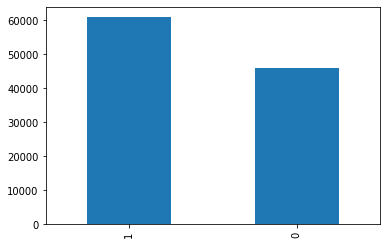

In [ ]:
# 훈련 데이터의 레이블 분포
train_data['label'].value_counts().plot(kind = 'bar')

print(train_data.groupby('label').size().reset_index(name = 'count'))
# 두 레이블의 비율은 차이가 있다. 


In [ ]:
!pip install konlpy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 4.3 MB/s 
     |████████████████████████████████| 453 kB 48.8 MB/s 


In [ ]:
# 형태소 분석
from konlpy.tag import Okt
okt = Okt()

stopwords = ['한', '할', '!', '~', "하다", '이', ".", "가", "을", "도", "에", "?", "은", "되다", "들", "..", "안", "는", "만", "있다", "...", "요", "를", "으로", "이다", "로", '다', '의', '좀', '못', '왜',"하", "에서","성", "고","아","게","1","생",",","네","거","그","내","뭐",'하고','나']


In [ ]:
train_data['tokenized'] = train_data['content'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
test_data['tokenized'] = test_data['content'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)


긍정 리뷰의 평균 길이 : 8.533998916238362
부정 리뷰의 평균 길이 : 14.4969597907813


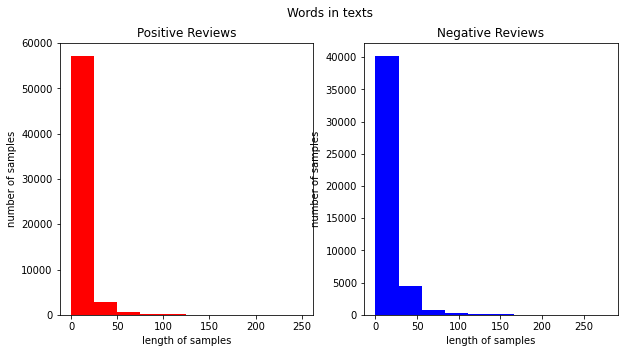

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 73486
등장 빈도가 1번 이하인 희귀 단어의 수: 42502
단어 집합에서 희귀 단어의 비율: 57.83686688620961
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5869542283980573


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 30986


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])


[[1, 3, 1615, 1], [387, 2296, 76, 224, 7, 218, 202, 30, 332, 84, 151, 229, 937, 1649], [7, 1051, 194, 3781, 4032, 265, 7079, 321, 1496]]


In [ ]:
print(X_test[:3])

[[4066, 2963, 74, 1568, 641, 2529, 137], [113, 1, 592, 104, 8776, 7, 755], [33, 227, 139]]


리뷰의 최대 길이 : 277
리뷰의 평균 길이 : 11.096278468684448


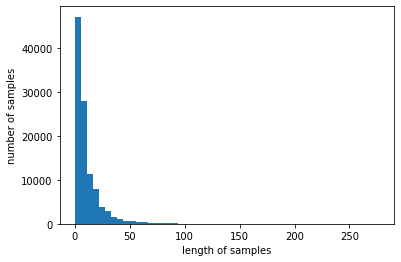

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 150
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 150 이하인 샘플의 비율: 99.94193886724602


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('sentiment_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1335/1335 [==============================] - ETA: 0s - loss: 0.4249 - acc: 0.8089
Epoch 1: val_acc improved from -inf to 0.82694, saving model to sentiment_model.h5
1335/1335 [==============================] - 380s 283ms/step - loss: 0.4249 - acc: 0.8089 - val_loss: 0.3917 - val_acc: 0.8269
Epoch 2/15
1335/1335 [==============================] - ETA: 0s - loss: 0.3720 - acc: 0.8390
Epoch 2: val_acc improved from 0.82694 to 0.82933, saving model to sentiment_model.h5
1335/1335 [==============================] - 368s 276ms/step - loss: 0.3720 - acc: 0.8390 - val_loss: 0.3854 - val_acc: 0.8293
Epoch 3/15
1335/1335 [==============================] - ETA: 0s - loss: 0.3522 - acc: 0.8507
Epoch 3: val_acc did not improve from 0.82933
1335/1335 [==============================] - 367s 275ms/step - loss: 0.3522 - acc: 0.8507 - val_loss: 0.3875 - val_acc: 0.8283
Epoch 4/15
1335/1335 [==============================] - ETA: 0s - loss: 0.3334 - acc: 0.8623
Epoch 4: val_acc did not improve

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
loaded_model = load_model('sentiment_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1113/1113 [==============================] - 39s 35ms/step - loss: 0.3929 - acc: 0.8258

 테스트 정확도: 0.8258


In [ ]:
sentiment_predict('별점 한개도 아깝습니다. 게임잘만들고 과금시스템으로 게임의 목적, 전통을 잃은 게임입니다.')

93.34% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('던전앤파이터 모바일을 즐기고 있는 유저입니다. 열심히 개발하시고 이것저것 이벤트 해주셔서 감사합니다만 살짝 아쉬운게 있어서 남겨봅니다.')

95.17% 확률로 긍정 리뷰입니다.
